In [1]:
import effector
import keras
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

# Load dataset
bike_sharing = effector.datasets.BikeSharing(pcg_train=0.8)
X_train, Y_train = bike_sharing.x_train, bike_sharing.y_train
X_test, Y_test = bike_sharing.x_test, bike_sharing.y_test

2025-02-26 10:52:28.059788: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define and train a neural network
model = keras.Sequential([
    keras.layers.Dense(1024, activation="relu"),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dense(1)
])
model.compile(optimizer="adam", loss="mse", metrics=["mae", keras.metrics.RootMeanSquaredError()])
model.fit(X_train, Y_train, batch_size=512, epochs=20, verbose=0)
loss, mae, rmse = model.evaluate(X_test, Y_test, verbose=1)

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0772 - mae: 0.1855 - root_mean_squared_error: 0.2760


In [3]:
def predict(x):
    return model(x).numpy().squeeze()

2025-02-26 10:52:43.826675: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 427130880 exceeds 10% of free system memory.
2025-02-26 10:52:43.901646: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 427130880 exceeds 10% of free system memory.
2025-02-26 10:52:43.964254: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 427130880 exceeds 10% of free system memory.
2025-02-26 10:52:44.583257: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 427130880 exceeds 10% of free system memory.
2025-02-26 10:52:44.665435: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 427130880 exceeds 10% of free system memory.


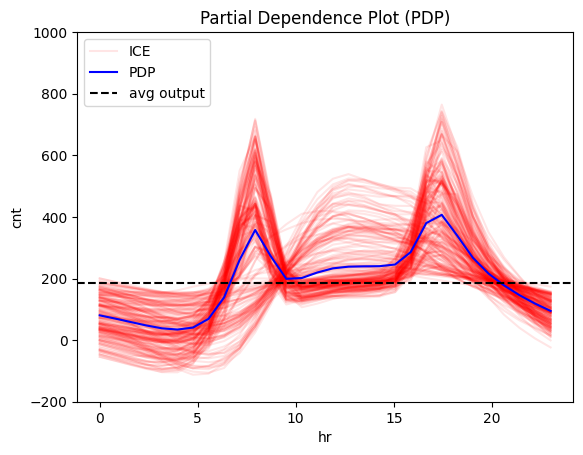

In [4]:
# Initialize the Partial Dependence Plot (PDP)
pdp = effector.PDP(
    X_test,  # Use the test set as background data
    predict,  # Prediction function
    feature_names=bike_sharing.feature_names,  # (optional) Feature names
    target_name=bike_sharing.target_name  # (optional) Target variable name
)

# Plot the effect of a feature
pdp.plot(
    feature=3,  # Select the 3rd feature (temperature) for the PDP plot
    nof_ice=200,  # (optional) Number of Individual Conditional Expectation (ICE) curves
    scale_x={"mean": bike_sharing.x_test_mu[3], "std": bike_sharing.x_test_std[3]},  # (optional) scale x-axis
    scale_y={"mean": bike_sharing.y_test_mu, "std": bike_sharing.y_test_std},  # (optional) scale y-axis
    centering=True,  # (optional) Center PDP and ICE curves
    show_avg_output=True,  # (optional) Display the average prediction
    y_limits=[-200, 1000]  # (optional) Set y-axis limits
)

In [5]:
# Initialize the Regional Partial Dependence Plot (RegionalPDP)
r_pdp = effector.RegionalPDP(
    X_test,  # Test set data
    predict,  # Prediction function
    feature_names=bike_sharing.feature_names,  # Feature names
    target_name=bike_sharing.target_name  # Target variable name
)

# Summarize the subregions of the 3rd feature (temperature)
r_pdp.summary(
    features=3,  # Select the 3rd feature for the summary
    scale_x_list=[  # scale each feature with mean and std
        {"mean": bike_sharing.x_test_mu[i], "std": bike_sharing.x_test_std[i]}
        for i in range(X_test.shape[1])
    ]
)

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]



Feature 3 - Full partition tree:
🌳 Full Tree Structure:
───────────────────────
hr 🔹 [id: 0 | heter: 0.38 | inst: 3476 | w: 1.00]
    workingday = 0.00 🔹 [id: 1 | heter: 0.28 | inst: 1129 | w: 0.32]
        temp ≤ 6.50 🔹 [id: 3 | heter: 0.14 | inst: 568 | w: 0.16]
        temp > 6.50 🔹 [id: 4 | heter: 0.16 | inst: 561 | w: 0.16]
    workingday ≠ 0.00 🔹 [id: 2 | heter: 0.27 | inst: 2347 | w: 0.68]
        temp ≤ 6.50 🔹 [id: 5 | heter: 0.18 | inst: 953 | w: 0.27]
        temp > 6.50 🔹 [id: 6 | heter: 0.19 | inst: 1394 | w: 0.40]
--------------------------------------------------
Feature 3 - Statistics per tree level:
🌳 Tree Summary:
─────────────────
Level 0🔹heter: 0.38
    Level 1🔹heter: 0.27 | 🔻0.11 (28.20%)
        Level 2🔹heter: 0.17 | 🔻0.10 (36.74%)




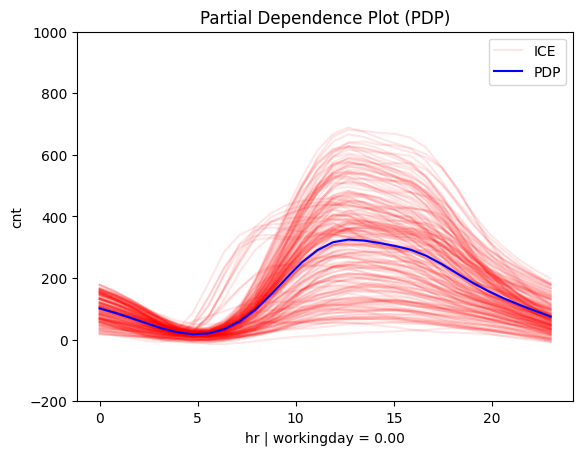

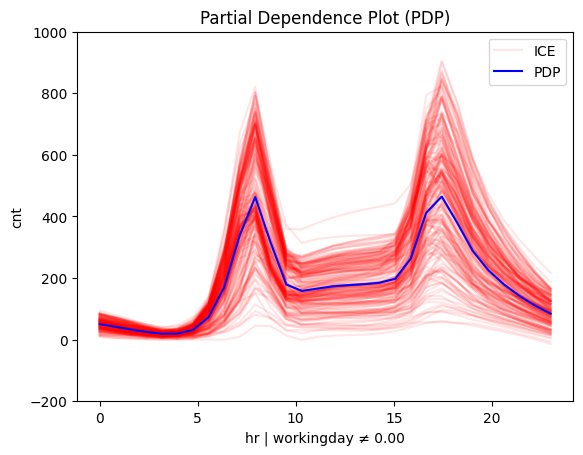

In [6]:
# Plot regional effects after the first-level split (workingday vs non-workingday)
for node_idx in [1, 2]:  # Iterate over the nodes of the first-level split
    r_pdp.plot(
        feature=3,  # Feature 3 (temperature)
        node_idx=node_idx,  # Node index (1: workingday, 2: non-workingday)
        nof_ice=200,  # Number of ICE curves
        scale_x_list=[  # Scale features by mean and std
            {"mean": bike_sharing.x_test_mu[i], "std": bike_sharing.x_test_std[i]}
            for i in range(X_test.shape[1])
        ],
        scale_y={"mean": bike_sharing.y_test_mu, "std": bike_sharing.y_test_std},  # Scale the target
        y_limits=[-200, 1000]  # Set y-axis limits
    )

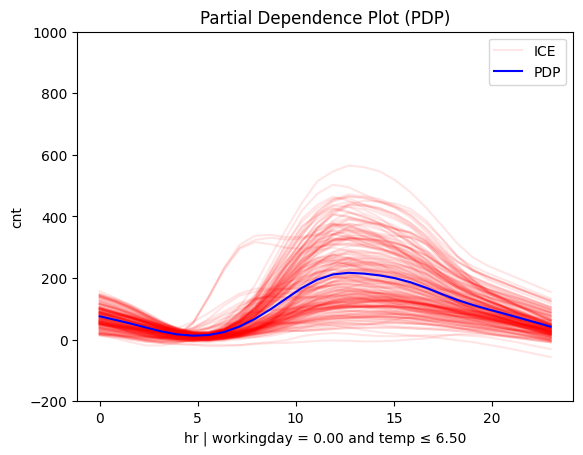

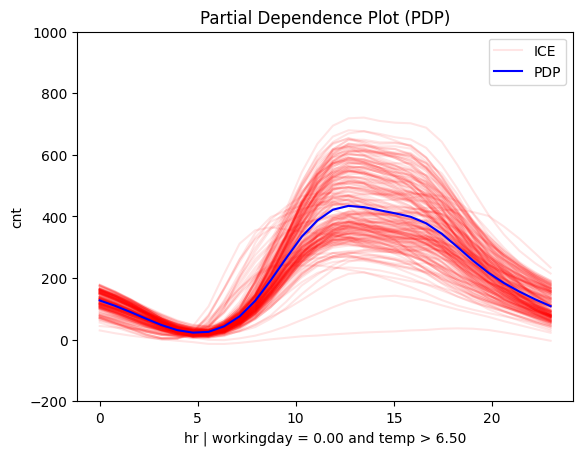

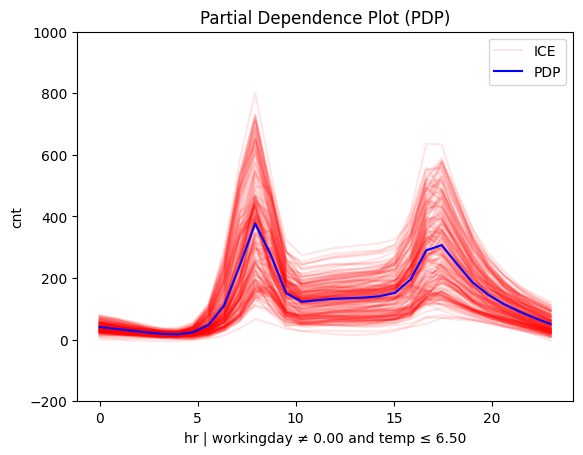

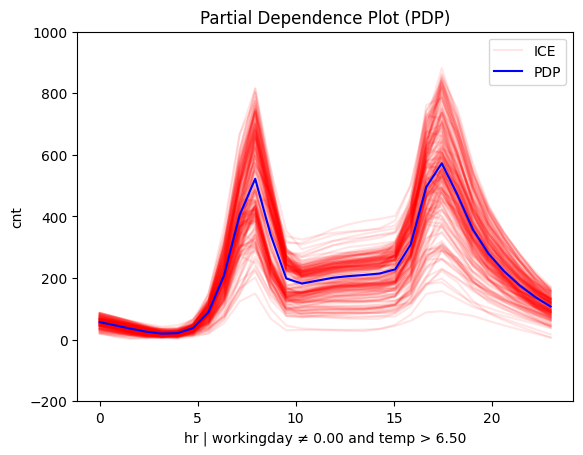

In [7]:
# Plot regional effects after second-level splits (workingday vs non-workingday and hot vs cold temperature)
for node_idx in [3, 4, 5, 6]:  # Iterate over the nodes of the second-level splits
    r_pdp.plot(
        feature=3,  # Feature 3 (temperature)
        node_idx=node_idx,  # Node index (hot/cold temperature and workingday/non-workingday)
        nof_ice=200,  # Number of ICE curves
        scale_x_list=[  # Scale features by mean and std
            {"mean": bike_sharing.x_test_mu[i], "std": bike_sharing.x_test_std[i]}
            for i in range(X_test.shape[1])
        ],
        scale_y={"mean": bike_sharing.y_test_mu, "std": bike_sharing.y_test_std},  # Scale target
        y_limits=[-200, 1000]  # Set y-axis limits
    )